<h2 style="color:orange;font-weight:bold;font-family:arial">Email Spam Detection and Filtering System</h2>
<h3 style="color:blue;font-weight:bold;font-family:arial">Samruddhi Khairnar</h3>

##### kbtug20170@kbtcoe.org

In [1]:
import pandas as pd

#### **Reading the Scraped Dataset**

In [2]:
df = pd.read_csv('emails_scraped.csv')
df['Spam'].replace({0:'non-spam',1:'spam'}, inplace=True)
df.head()

,Data,Spam
0,"Best wishes,",non-spam
1,[Your Post 1],non-spam
2,Free access,spam
3,Thank you for signing up for [your company nam...,non-spam
4,Accept credit cards,spam


#### **Splitting the Dataset into Training + Testing Set**

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
train, test = train_test_split(df, test_size=0.3, random_state=34)
train_x, train_y = train['Data'], train['Spam']
test_x, test_y = test['Data'], test['Spam']

In [5]:
train_x.shape

(436,)

#### **Lemmatization** 
##### (Getting root words from words eg: playful -> play)

In [6]:
import nltk
#nltk.download('stopwords');nltk.download('punkt');nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
import re

In [7]:
wnl = WordNetLemmatizer()
data = np.array(df['Data'])

In [8]:
for i,d in enumerate(data):
    d = re.sub(r'[^\w\s]','',d)
    
    words = word_tokenize(d)
    lemmatized = []
    for w in words:
        lemmatized.append(wnl.lemmatize(w))
        
    data[i] = " ".join(lemmatized)

In [9]:
data[:5]

array(['Best wish', 'Your Post 1', 'Free access',
       'Thank you for signing up for your company name news center Well be updating you on occasion about productsservices you offer and other update about your company',
       'Accept credit card'], dtype=object)

#### **Stopwords Removal** 
##### (Remove common words eg: the,if..)

In [10]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [11]:
s = stopwords.words('english')

In [12]:
for i,d in enumerate(data):    
    words = word_tokenize(d)

    stripped = []
    for w in words:
        if w not in s:
            stripped.append(w)

    data[i] = " ".join(stripped)

In [13]:
data[:5]

array(['Best wish', 'Your Post 1', 'Free access',
       'Thank signing company name news center Well updating occasion productsservices offer update company',
       'Accept credit card'], dtype=object)

#### **Bag of Words Vectorization** 
##### (creation of feature vectors eg:10110)

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(binary=True, ngram_range=(1,2))

In [15]:
train_x_bag = vectorizer.fit_transform(train_x)
test_x_bag = vectorizer.transform(test_x)

In [16]:
print(vectorizer.get_feature_names_out())
print(train_x_bag.toarray()[0])

['30' '30 minutes' '301' ... 'youtube your' 'yyyy' 'zone']
[0. 0. 0. ... 0. 0. 0.]


#### **Visualization of Most Frequent Words** 

In [17]:
spam, non_spam = df.loc[df['Spam']=='spam'], df.loc[df['Spam']!='spam']

In [18]:
spam_bag = vectorizer.fit_transform(spam['Data']).toarray()
spam_bag_sum = np.sum(spam_bag, axis=0)
spam_df = pd.DataFrame({'sum':spam_bag_sum,'feature':vectorizer.get_feature_names_out()})
spam_df.sort_values(by='sum', ascending=False, inplace=True)

In [19]:
non_spam_bag = vectorizer.fit_transform(non_spam['Data']).toarray()
non_spam_bag_sum = np.sum(non_spam_bag, axis=0)
non_spam_df = pd.DataFrame({'sum':non_spam_bag_sum,'feature':vectorizer.get_feature_names_out()})
non_spam_df.sort_values(by='sum', ascending=False, inplace=True)

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

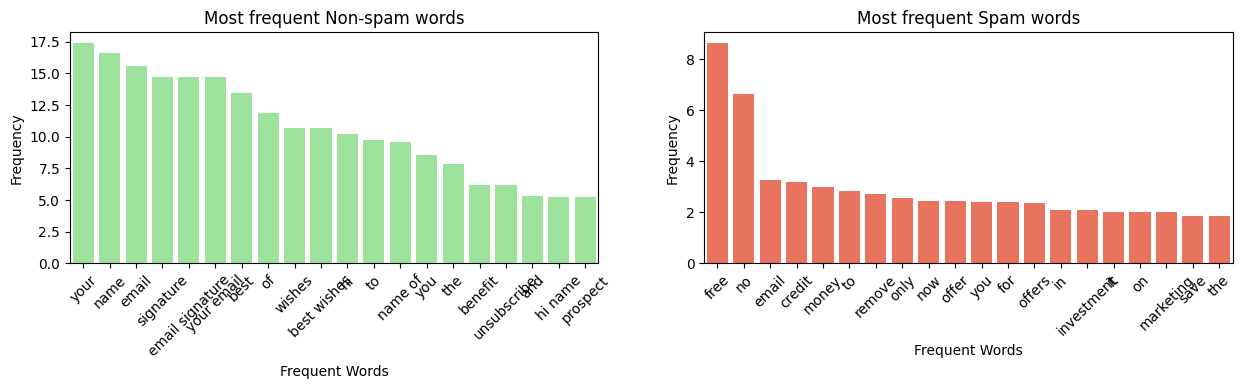

In [21]:
fig, ax = plt.subplots(1,2,  figsize=(15, 3))

sns.barplot(ax=ax[0],x='feature', y='sum', data=non_spam_df[:20], color='lightgreen')
sns.barplot(ax=ax[1], x='feature', y='sum', data=spam_df[:20], color='tomato')

ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)

ax[0].set_xlabel('Frequent Words'); ax[0].set_ylabel('Frequency')
ax[1].set_xlabel('Frequent Words'); ax[1].set_ylabel('Frequency')
ax[0].set_title('Most frequent Non-spam words');
ax[1].set_title('Most frequent Spam words');

#### **Word Vectors using Spacy** 
##### (Word Vectors are like bag of words but including Semantics)

In [22]:
import spacy
# !python3 -m spacy download en_core_web_md

In [23]:
sp = spacy.load('en_core_web_md')

In [24]:
train_x_wv = [sp(x).vector for x in train_x] 
test_x_wv = [sp(x).vector for x in test_x] 

#### **Classifiers** 

In [25]:
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

#### **Support Vector Machine**

In [26]:
from sklearn.svm import SVC
svm = SVC()

# Hyperparameter Tuning
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','poly','sigmoid']} 
  
svm_grid = GridSearchCV(svm, param_grid, refit = True, verbose = 0)

In [27]:
# Bag of Words Vectors
svm = svm_grid.fit(train_x_bag, train_y)
print('Accuracy = ', svm.score(test_x_bag, test_y))
print('F1 Score = ', f1_score(test_y, svm.predict(test_x_bag), average=None, labels=['spam','non-spam']) )

Accuracy =  0.93048128342246
F1 Score =  [0.90780142 0.94420601]


In [28]:
# Spacy Word Vectors
svm = svm_grid.fit(train_x_wv, train_y)
print('Accuracy = ', svm.score(test_x_wv, test_y))
print('F1 Score = ', f1_score(test_y, svm.predict(test_x_wv), average=None, labels=['spam','non-spam']) )

Accuracy =  0.9946524064171123
F1 Score =  [0.99328859 0.99555556]


#### **Decision Tree Classifier**

In [29]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()

# Hyperparameter Tuning
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}
dtc_grid = GridSearchCV(estimator=dtc, param_grid=params, cv=3, verbose=0, scoring='accuracy') 

In [30]:
# Bag of Words Vectors
dtc_grid.fit(train_x_bag, train_y)
print('Accuracy = ', dtc_grid.score(test_x_bag, test_y))
print('F1 Score = ', f1_score(test_y, dtc_grid.predict(test_x_bag), average=None, labels=['spam','non-spam']) )

Accuracy =  0.7914438502673797
F1 Score =  [0.77966102 0.80203046]


In [31]:
# Spacy Word Vectors
dtc_grid.fit(train_x_wv, train_y)
print('Accuracy = ', dtc_grid.score(test_x_wv, test_y))
print('F1 Score = ', f1_score(test_y, dtc_grid.predict(test_x_wv), average=None, labels=['spam','non-spam']) )

Accuracy =  0.8609625668449198
F1 Score =  [0.82432432 0.88495575]


#### **Naive Bayes Classifier**

In [32]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()

# Hyperparameter Tuning
params = {'var_smoothing': np.logspace(0,-9, num=100)}
nb_grid = GridSearchCV(estimator=nb, param_grid=params, cv=3, verbose=0, scoring='accuracy') 

In [33]:
# Bag of Words Vectors
nb_grid.fit(train_x_bag.toarray(), train_y)
print('Accuracy = ', nb_grid.score(test_x_bag.toarray(), test_y))
print('F1 Score = ', f1_score(test_y, nb_grid.predict(test_x_bag.toarray()), average=None, labels=['spam','non-spam']) )

Accuracy =  0.8609625668449198
F1 Score =  [0.8        0.89344262]


In [34]:
# Spacy Word Vectors
nb_grid.fit(train_x_wv, train_y)
print('Accuracy = ', nb_grid.score(test_x_wv, test_y))
print('F1 Score = ', f1_score(test_y, nb_grid.predict(test_x_wv), average=None, labels=['spam','non-spam']) )

Accuracy =  0.9197860962566845
F1 Score =  [0.90797546 0.92890995]


#### **Logistic Regression**

In [35]:
from sklearn.linear_model import LogisticRegression

# Hyperparameter Tuning
lr = LogisticRegression(max_iter=2000)
param_grid = [    
    {'penalty' : ['l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear'],
    }
]
lr_grid = GridSearchCV(lr, param_grid = param_grid, cv = 3, verbose=False, n_jobs=-1)

In [36]:
# Bag of Words Vectors
lr = lr_grid.fit(train_x_bag, train_y)
print('Accuracy = ', lr.score(test_x_bag, test_y))
print('F1 Score = ', f1_score(test_y, lr.predict(test_x_bag), average=None, labels=['spam','non-spam']) )

Accuracy =  0.9358288770053476
F1 Score =  [0.91666667 0.94782609]


In [37]:
# Spacy Word Vectors
lr = lr_grid.fit(train_x_wv, train_y)
print('Accuracy = ', lr.score(test_x_wv, test_y))
print('F1 Score = ', f1_score(test_y, lr.predict(test_x_wv), average=None, labels=['spam','non-spam']) )

Accuracy =  0.9732620320855615
F1 Score =  [0.96598639 0.97797357]


#### **Saving the Best Model**
##### (SVM Model using Word Vectors)

In [38]:
import pickle
with open('email_spam_filter.pkl','wb') as f:
    pickle.dump(svm, f)

In [39]:
with open('email_spam_filter.pkl','rb') as f:
    loaded = pickle.load(f)
loaded.predict([sp('Please pay me quickly').vector])

array(['spam'], dtype=object)